#<b><font color="purple"> 🧠 Train - test - predict 🧠</font></b>

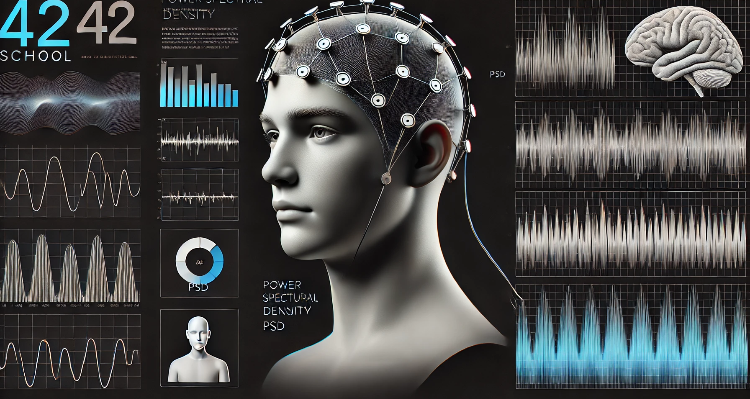

##<b><font color="blue">Project info</font></b>
* EEG data from 109 subjects. The dataset includes 6 experiments, detailed information is available [here](https://physionet.org/content/eegmmidb/1.0.0/).

### ***Experiments Overview***

| **Experiment**  | **Duration** | **Condition**          | **Events**                  | **Runs per Subject** |
|-----------------|--------------|------------------------|-----------------------------|----------------------|
| **baseline01** Run [1] | 60 seconds   | Eyes open              | 1 event (T0 at the start)   | 1                    |
| **baseline02** Run [2]  | 60 seconds   | Eyes closed            | 1 event (T1 at the start)   | 1                    |

### ***Task-Based Experiments***

Each subject repeats the following tasks three times, totaling 12 runs (plus the 2 baseline runs), making it 14 runs per subject.

| **Task**  | **Duration** | **Events**                                                                                             |
|-----------|--------------|--------------------------------------------------------------------------------------------------------|
| **Task01** Runs [3, 7, 11]| 120 seconds  | 3 events: T0 rest (4 sec), T1 open/close left fist (4 sec), T2 open/close right fist (4 sec)           |
| **Task02** Runs [4, 8, 12]| 120 seconds  | 3 events: T0 rest (4 sec), T1 imagine open/close left fist (4 sec), T2 imagine open/close right fist (4 sec) |
| **Task03** Runs [5, 9, 13]| 120 seconds  | 3 events: T0 rest (4 sec), T1 open/close both fists (4 sec), T2 open/close both feet (4 sec)           |
| **Task04** Runs [6, 10, 14]| 120 seconds  | 3 events: T0 rest (4 sec), T1 imagine open/close both fists (4 sec), T2 imagine open/close both feet (4 sec) |

### ***Objective:***
The goal is to predict whether an event in a given task and run is T1 or T2. For example, using data from run 2 of Task03 for subject 23, we aim to classify whether the action events are T1 or T2, ignoring T0 events.

### ***Model Design:***
Since the events in one task are unrelated to events in another task, we will build a model that contains submodels for each task, resulting in four distinct submodels, one for each task.


### **Rationale for Excluding T0 Events**

In the context of the EEG data, the events labeled as T0 correspond to a resting state where no specific task-related activity is occurring. This is in contrast to the T1 and T2 events, which represent specific actions or imagined actions (e.g., moving a fist or foot).

#### Reasons for Exclusion:

1. **Irrelevance to Classification Goal:**
   The primary objective of this project is to classify the specific task-related events (T1 and T2). Including T0, which represents a resting state, would introduce noise into the model, as it does not provide information relevant to distinguishing between the T1 and T2 events.

2. **Simplification of the Problem:**
   By excluding T0 events, we simplify the classification task to a binary problem (i.e., distinguishing between T1 and T2). This makes the model more focused and potentially more accurate in predicting the specific events of interest.

3. **Consistency in Data Structure:**
   Since T0 is a common resting event across all tasks, including it could lead to inconsistencies or imbalances in the data, where the model might learn to easily distinguish resting from active states but struggle with differentiating between the subtle differences of T1 and T2.

4. **Focus on Action-Related Brain Activity:**
   The brain's activity during T0 is fundamentally different from that during T1 and T2, which involve specific motor or imagined motor tasks. By focusing only on T1 and T2, the model can better capture the neural patterns associated with these actions, leading to more meaningful and actionable predictions.


#<b><font color="blue">Libraries and modules</font></b>

In [1]:
!pip install mne

Looking in indexes: https://pypi.python.org/simple


In [2]:
import mne
import warnings
import numpy as np
import pandas as pd
import time
from tqdm import tqdm
from IPython.display import display, HTML
from typing import List

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.exceptions import ConvergenceWarning

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP

mne.set_log_level("CRITICAL")

# Suppress warnings from LogisticRegression and CSP
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn.linear_model._logistic')
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning, module='mne')

#<b><font color="blue">Classes - BaseEstimator - TransformerMixin - Custom Classifier</font></b>

In [3]:
class EEGStandardScaler(BaseEstimator, TransformerMixin):
    """
    Custom scaler for 3D EEG data arrays.

    Attributes:
        scaler (StandardScaler): The standard scaler applied to the data.
    """

    def __init__(self) -> None:
        """
        Initializes the EEGStandardScaler.
        """
        self.scaler = StandardScaler()

    def fit(self, X: np.ndarray, y: np.ndarray = None) -> 'EEGStandardScaler':
        """
        Fits the scaler on the EEG data.

        Parameters:
            X (np.ndarray): Input data of shape (n_epochs, n_channels, n_times).
            y (np.ndarray, optional): Target values (ignored).

        Returns:
            EEGStandardScaler: Returns the fitted scaler instance.
        """
        n_epochs, n_channels, n_times = X.shape
        self.scaler.fit(X.reshape(n_epochs * n_channels, n_times))
        return self

    def transform(self, X: np.ndarray, y: np.ndarray = None) -> np.ndarray:
        """
        Transforms the EEG data using the fitted scaler.

        Parameters:
            X (np.ndarray): Input data of shape (n_epochs, n_channels, n_times).
            y (np.ndarray, optional): Target values (ignored).

        Returns:
            np.ndarray: Scaled data of shape (n_epochs, n_channels, n_times).
        """
        n_epochs, n_channels, n_times = X.shape
        X_scaled = self.scaler.transform(X.reshape(n_epochs * n_channels, n_times))
        return X_scaled.reshape(n_epochs, n_channels, n_times)

    def get_params(self, deep: bool = True) -> dict:
        """
        Get parameters for this estimator.

        Parameters:
            deep (bool): If True, will return the parameters for this estimator and contained subobjects that are estimators.

        Returns:
            dict: Parameters of the estimator.
        """
        return {}

    def set_params(self, **params) -> 'EEGStandardScaler':
        """
        Set the parameters of the scaler.

        Parameters:
            params (dict): Dictionary of parameters to set.

        Returns:
            EEGStandardScaler: The scaler instance with updated parameters.
        """
        self.scaler.set_params(**params)
        return self

In [4]:
class Float64CSP(CSP):
    """
    CSP class that converts input data to float64 for precision.

    Inherits from:
        CSP: The standard CSP class from MNE.
    """

    def fit(self, X: np.ndarray, y: np.ndarray) -> 'Float64CSP':
        """
        Fit the CSP model.

        Parameters:
            X (np.ndarray): The input data to fit, of shape (n_epochs, n_channels, n_times).
            y (np.ndarray): The class labels corresponding to the input data.

        Returns:
            Float64CSP: The fitted CSP model.
        """
        X = X.astype(np.float64)
        return super().fit(X, y)

    def transform(self, X: np.ndarray) -> np.ndarray:
        """
        Transform the input data using the fitted CSP model.

        Parameters:
            X (np.ndarray): The input data to transform, of shape (n_epochs, n_channels, n_times).

        Returns:
            np.ndarray: The transformed data.
        """
        X = X.astype(np.float64)
        return super().transform(X)

In [5]:
class CustomClassifier(BaseEstimator, ClassifierMixin):
    """
    A custom classifier that predicts based on the nearest class mean.

    Attributes:
        scaler_ (StandardScaler): Scaler to standardize input data.
        class_means_ (dict): Dictionary storing the mean vectors of each class.
        classes_ (np.ndarray): Array of class labels.
    """

    def __init__(self) -> None:
        """
        Initializes the CustomClassifier.
        """
        pass  # No parameters to initialize

    def fit(self, X: np.ndarray, y: np.ndarray) -> 'CustomClassifier':
        """
        Fit the classifier to the data by calculating the mean vector for each class.

        Parameters:
            X (np.ndarray): Input data of shape (n_samples, n_features).
            y (np.ndarray): Target values (class labels).

        Returns:
            CustomClassifier: The fitted classifier instance.
        """
        X, y = check_X_y(X, y)
        self.scaler_ = StandardScaler().fit(X)
        X = self.scaler_.transform(X)

        self.class_means_ = {}
        for label in np.unique(y):
            self.class_means_[label] = X[y == label].mean(axis=0)

        self.classes_ = np.unique(y)
        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Predict the class labels for the input data.

        Parameters:
            X (np.ndarray): Input data of shape (n_samples, n_features).

        Returns:
            np.ndarray: Predicted class labels.
        """
        check_is_fitted(self, ['class_means_'])
        X = check_array(X)
        X = self.scaler_.transform(X)

        predictions = []
        for x in X:
            distances = {label: np.linalg.norm(x - mean) for label, mean in self.class_means_.items()}
            predictions.append(min(distances, key=distances.get))
        return np.array(predictions)

In [6]:
class FourierTransform(BaseEstimator, TransformerMixin):
    """
    Applies Fourier Transform to EEG data.

    Methods:
        fit: Placeholder method to fit the transformer.
        transform: Applies the Fourier Transform and returns the magnitude of the coefficients.
    """

    def fit(self, X: np.ndarray, y: np.ndarray = None) -> 'FourierTransform':
        """
        Fit the FourierTransform (no operation, included for compatibility).

        Parameters:
            X (np.ndarray): Input data of shape (n_epochs, n_channels, n_times).
            y (np.ndarray, optional): Target values (ignored).

        Returns:
            FourierTransform: The transformer instance.
        """
        return self

    def transform(self, X: np.ndarray, y: np.ndarray = None) -> np.ndarray:
        """
        Apply the Fourier Transform to the input data.

        Parameters:
            X (np.ndarray): Input data of shape (n_epochs, n_channels, n_times).
            y (np.ndarray, optional): Target values (ignored).

        Returns:
            np.ndarray: The magnitude of the Fourier coefficients.
        """
        X_fft = np.fft.rfft(X, axis=-1)
        return np.abs(X_fft)

    def get_params(self, deep: bool = True) -> dict:
        """
        Get parameters for this transformer.

        Parameters:
            deep (bool): If True, will return the parameters for this transformer and contained subobjects that are estimators.

        Returns:
            dict: Parameters of the transformer.
        """
        return {}

    def set_params(self, **params) -> 'FourierTransform':
        """
        Set the parameters of the transformer.

        Parameters:
            params (dict): Dictionary of parameters to set.

        Returns:
            FourierTransform: The transformer instance with updated parameters.
        """
        return self

#<b><font color="blue">Functions for data impporting and preprocessing</font></b>

In [7]:
def rename_channels(raw) -> None:
    """
    Rename channels to match the standard 1005 montage.

    Parameters:
        raw: The raw EEG data object whose channels are to be renamed.

    Returns:
        None
    """
    mapping = {
        'Fc5.': 'FC5', 'Fc3.': 'FC3', 'Fc1.': 'FC1', 'Fcz.': 'FCz', 'Fc2.': 'FC2', 'Fc4.': 'FC4', 'Fc6.': 'FC6',
        'C5..': 'C5', 'C3..': 'C3', 'C1..': 'C1', 'Cz..': 'Cz', 'C2..': 'C2', 'C4..': 'C4', 'C6..': 'C6',
        'Cp5.': 'CP5', 'Cp3.': 'CP3', 'Cp1.': 'CP1', 'Cpz.': 'CPz', 'Cp2.': 'CP2', 'Cp4.': 'CP4', 'Cp6.': 'CP6',
        'Fp1.': 'Fp1', 'Fpz.': 'Fpz', 'Fp2.': 'Fp2', 'Af7.': 'AF7', 'Af3.': 'AF3', 'Afz.': 'AFz', 'Af4.': 'AF4', 'Af8.': 'AF8',
        'F7..': 'F7', 'F5..': 'F5', 'F3..': 'F3', 'F1..': 'F1', 'Fz..': 'Fz', 'F2..': 'F2', 'F4..': 'F4', 'F6..': 'F6', 'F8..': 'F8',
        'Ft7.': 'FT7', 'Ft8.': 'FT8', 'T7..': 'T7', 'T8..': 'T8', 'T9..': 'T9', 'T10.': 'T10', 'Tp7.': 'TP7', 'Tp8.': 'TP8',
        'P7..': 'P7', 'P5..': 'P5', 'P3..': 'P3', 'P1..': 'P1', 'Pz..': 'Pz', 'P2..': 'P2', 'P4..': 'P4', 'P6..': 'P6', 'P8..': 'P8',
        'Po7.': 'PO7', 'Po3.': 'PO3', 'Poz.': 'POz', 'Po4.': 'PO4', 'Po8.': 'PO8', 'O1..': 'O1', 'Oz..': 'Oz', 'O2..': 'O2', 'Iz..': 'Iz'
    }
    raw.rename_channels(mapping)

In [8]:
def load_and_preprocess_data(subjects: list[int], runs: list[int]) -> Epochs:
    """
    Load and preprocess EEG data for given subjects and runs.

    Parameters:
        subjects (list[int]): List of subject IDs to load the data for.
        runs (list[int]): List of run IDs corresponding to the experiments.

    Returns:
        Epochs: Concatenated epochs of the preprocessed EEG data.
    """
    all_epochs = []
    for subject in subjects:
        raw_fnames = eegbci.load_data(subject, runs)
        raws = [read_raw_edf(f, preload=True) for f in raw_fnames]
        raw = concatenate_raws(raws)

        rename_channels(raw)

        raw.notch_filter(freqs=60)

        montage = make_standard_montage('standard_1005')
        raw.set_montage(montage)
        raw.filter(7., 32., fir_design='firwin', skip_by_annotation='edge')

        events, _ = events_from_annotations(raw)

        event_id = dict(T1=1, T2=2)  # Only keep T1 and T2
        epochs = Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=pick_types(raw.info, eeg=True), baseline=None, preload=True)

        epochs = epochs.crop(tmin= 1., tmax=2.)

        all_epochs.append(epochs)

    return mne.concatenate_epochs(all_epochs)

#<b><font color="blue">Functions for training - cross validation - testing</font></b>

In [9]:
def define_models() -> dict:
    """
    Define and return a dictionary of machine learning model pipelines.

    Returns:
        models: A dictionary where keys are model names (str) and values are sklearn Pipeline objects.
    """

    # Define the Logistic Regression pipeline
    logistic_regression = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(max_iter=10000))
    ])
    # Display the pipeline
    display(logistic_regression)

    # Define the Fourier + CSP + LDA pipeline
    fourier_csp_lda = Pipeline([
        ('fourier', FourierTransform()),                 # Apply Fourier Transform to the data
        ('scaler', EEGStandardScaler()),                 # Standardise the data
        ('CSP', Float64CSP(n_components=4, reg=None, log=True)),  # Apply Common Spatial Patterns (CSP)
        ('LDA', LinearDiscriminantAnalysis())            # Use Linear Discriminant Analysis for classification
    ])
    # Display the pipeline
    display(fourier_csp_lda)

    # Define the Fourier + CSP + SVM pipeline
    fourier_csp_svm = Pipeline([
        ('fourier', FourierTransform()),                 # Apply Fourier Transform to the data
        ('scaler', EEGStandardScaler()),                 # Standardise the data
        ('CSP', Float64CSP(n_components=4, reg=None, log=True)),  # Apply Common Spatial Patterns (CSP)
        ('SVM', SVC(kernel='linear'))                    # Use Support Vector Machine with a linear kernel
    ])
    # Display the pipeline
    display(fourier_csp_svm)

    # Define the Fourier + PCA + Logistic Regression pipeline
    fourier_pca_logreg = Pipeline([
        ('fourier', FourierTransform()),                 # Apply Fourier Transform to the data
        ('scaler', StandardScaler()),                    # Standardise the data
        ('PCA', PCA(n_components=9)),                    # Apply Principal Component Analysis (PCA) for dimensionality reduction
        ('clf', LogisticRegression(max_iter=10000))      # Use Logistic Regression for classification
    ])
    # Display the pipeline
    display(fourier_pca_logreg)

    # Define the Fourier + Custom Classifier pipeline
    fourier_custom = Pipeline([
        ('fourier', FourierTransform()),                 # Apply Fourier Transform to the data
        ('scaler', StandardScaler()),                    # Standardise the data
        ('clf', CustomClassifier())                      # Use custom classifier for classification
    ])
    # Display the pipeline
    display(fourier_custom)

    # Update the list of models
    models = {
        'Logistic Regression': logistic_regression,        # Logistic Regression pipeline
        'Fourier + CSP + LDA': fourier_csp_lda,            # Fourier Transform + CSP + LDA pipeline
        'Fourier + CSP + SVM': fourier_csp_svm,            # Fourier Transform + CSP + SVM pipeline
        'Fourier + PCA + Logistic Regression': fourier_pca_logreg,  # Fourier Transform + PCA + Logistic Regression pipeline
        'Fourier + Custom Classifier': fourier_custom      # Fourier Transform + Custom Classifier pipeline
    }

    return models

In [26]:
def evaluate_models(models: dict,
                    train_tasks: dict,
                    test_tasks: dict,
                    train_subjects: list[int],
                    test_subjects: list[int]) -> pd.DataFrame:
    """
    Train and evaluate models on the given tasks and subjects.

    Parameters:
        models (dict): Dictionary where keys are model names and values are sklearn Pipeline objects representing different models.
        train_tasks (dict): Dictionary mapping task names to lists of run IDs that should be used for training.
        test_tasks (dict): Dictionary mapping task names to lists of run IDs that should be used for testing.
        train_subjects (list[int]): List of subject IDs to be used for training the models.
        test_subjects (list[int]): List of subject IDs to be used for testing the models.

    Returns:
        df_all_task_performance: A DataFrame containing the performance metrics (e.g., cross-validation accuracy, train accuracy, test accuracy) for each model and task.
    """
    all_task_performance = []

    task_names = list(train_tasks.keys())  # Get the list of task names

    # Loop over each task with a customized tqdm progress bar
    display(HTML(f'<h1 style="color: darkred;">🛠️ Training, cross validating and testing the models</h1>'))
    for i, (task_name, train_runs) in enumerate(tqdm(train_tasks.items(),
                                                     desc=f"🛠️ Processing Tasks:",
                                                     bar_format="{l_bar}🟩{bar:20}🟩{r_bar}")):
        # Display a message for the current task in h2
        display(HTML(f'<h2 style="color: green;">🛠️ Processing Task: {task_name}</h2>'))

        # Load and preprocess training data for the current task
        train_epochs = load_and_preprocess_data(train_subjects, train_runs)
        input(f"i: {i}, Train_subjects: {train_subjects}, Task_name: {task_name}, Train_runs: {train_runs}") 
        X_train = train_epochs.get_data().astype(np.float64)  # Ensure data is double floating point precision
        y_train = train_epochs.events[:, -1]

        # Load and preprocess testing data for the current task
        test_runs = test_tasks[task_name]
        test_epochs = load_and_preprocess_data(test_subjects, test_runs)
        input(f"i: {i}, Test_subjects: {test_subjects}, Task_name: {task_name}, Test_runs: {test_runs}")
        X_test = test_epochs.get_data().astype(np.float64)  # Ensure data is double floating point precision
        y_test = test_epochs.events[:, -1]

        # Initialize a list to store model performance data
        model_performance = []

        # Define parameter grid for grid search
        param_grid_pca = {
            'PCA__n_components': [4, 9, 20]
        }

        param_grid_csp = {
            'CSP__n_components': [4, 9, 20]
        }

        # Train and evaluate each model using cross_val_score and GridSearchCV
        for model_name, model in tqdm(models.items(),
                                      desc=f"🔍 Evaluating Models for {task_name}",
                                      leave=False,
                                      bar_format="{l_bar}🟩{bar:20}🟩{r_bar}"):
            # Display a message for the inner loop in h4
            display(HTML(f'<h4 style="color: blue; margin-left: 20px;">🔍 Evaluating Models for {task_name}</h4>'))

            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=ConvergenceWarning)
                if 'PCA' in model_name:
                    X_train_reshaped = model.named_steps['fourier'].transform(X_train)
                    X_test_reshaped = model.named_steps['fourier'].transform(X_test)
                    grid_search = GridSearchCV(model, param_grid_pca, cv=5, n_jobs=-1)
                    grid_search.fit(X_train_reshaped.reshape(len(X_train_reshaped), -1), y_train)
                    best_model = grid_search.best_estimator_
                    cv_score = grid_search.best_score_
                    best_params = grid_search.best_params_
                    train_score = best_model.score(X_train_reshaped.reshape(len(X_train_reshaped), -1), y_train)
                    test_score = best_model.score(X_test_reshaped.reshape(len(X_test_reshaped), -1), y_test)
                elif 'CSP' in model_name:
                    grid_search = GridSearchCV(model, param_grid_csp, cv=5, n_jobs=-1)
                    grid_search.fit(X_train, y_train)
                    best_model = grid_search.best_estimator_
                    cv_score = grid_search.best_score_
                    best_params = grid_search.best_params_
                    train_score = best_model.score(X_train, y_train)
                    test_score = best_model.score(X_test, y_test)
                else:
                    cv_scores = cross_val_score(model, X_train.reshape(len(X_train), -1), y_train, cv=5)
                    model.fit(X_train.reshape(len(X_train), -1), y_train)
                    cv_score = np.mean(cv_scores)
                    best_params = {}
                    train_score = model.score(X_train.reshape(len(X_train), -1), y_train)
                    test_score = model.score(X_test.reshape(len(X_test), -1), y_test)

                print(f"Task: {task_name}, Model: {model_name}")
                print(f"Cross-Val Accuracy: {cv_score:.2%}")
                print(f"Train Accuracy: {train_score:.2%}")
                print(f"Test Accuracy: {test_score:.2%}")

                # Append performance data to the list
                model_performance.append({
                    'Task': task_name,
                    'Model': model_name,
                    'Params': best_params,
                    'Cross-Val Mean Accuracy': cv_score,
                    'Train Accuracy': train_score,
                    'Test Accuracy': test_score
                })

        # Append the task performance data to the all_task_performance list
        all_task_performance.extend(model_performance)

        # Conditionally print a message if it's not the last task
        if i < len(task_names) - 1:
            display(HTML(f'<h2 style="color: darkorange;">✅ Finished: {task_name}. 🚀 Moving to the next task...</h2><br><br>'))

    # Create a DataFrame from the performance data
    df_all_task_performance = pd.DataFrame(all_task_performance)

    return df_all_task_performance

In [11]:
def identify_best_models(df_all_task_performance: pd.DataFrame) -> pd.DataFrame:
    """
    Identify and return the best models for each task.

    Parameters:
        df_all_task_performance (pd.DataFrame): DataFrame containing performance metrics for each model and task.

    Returns:
        best_models: A DataFrame containing the best model for each task based on test accuracy.
    """
    best_models = df_all_task_performance.sort_values(by=['Task', 'Test Accuracy', 'Train Accuracy'], ascending=[True, False, False]).groupby('Task').first()

    print("\nBest Models for Each Task:")
    print(best_models)

    # Calculate and print the mean accuracies of the best models
    mean_train_accuracy = best_models['Train Accuracy'].mean()
    mean_test_accuracy = best_models['Test Accuracy'].mean()
    mean_cv_accuracy = best_models['Cross-Val Mean Accuracy'].mean()

    print("\nMean of Best Model Accuracies:")
    print(f"Mean Train Accuracy: {mean_train_accuracy:.2%}")
    print(f"Mean Cross-Val Accuracy: {mean_cv_accuracy:.2%}")
    print(f"Mean Test Accuracy: {mean_test_accuracy:.2%}")

    return best_models

#<b><font color="blue">Function for simulating real time predictions</font></b>

In [1]:
def simulate_real_time_prediction(best_models: pd.DataFrame,
                                  predict_subject: list[int],
                                  task_name: str,
                                  task_run: list[int],
                                  X_train: np.ndarray,
                                  y_train: np.ndarray) -> None:
    """
    Simulate real-time prediction using the best model for a given task.

    Parameters:
        best_models (pd.DataFrame): DataFrame containing the best model for each task.
        predict_subject (list[int]): List containing the subject ID to be predicted.
        task_name (str): The name of the task to be predicted.
        task_run (list[int]): List of run IDs corresponding to the task.
        X_train (np.ndarray): Training data used to fit the best model.
        y_train (np.ndarray): Training labels used to fit the best model.

    Returns:
        None
    """
    # Load and preprocess the real-time prediction data
    real_time_epochs = load_and_preprocess_data(predict_subject, task_run)
    X_real_time = real_time_epochs.get_data().astype(np.float64)  # Ensure data is double floating point precision
    y_real_time = real_time_epochs.events[:, -1]

    # Extract timestamps for each event
    timestamps = real_time_epochs.events[:, 0] / real_time_epochs.info['sfreq']

    # Select the best model for the given task
    best_model_name = best_models.loc[task_name, 'Model']
    models = define_models()
    best_model = models[best_model_name]
    print(f"predicting events in {task_name}, for subject {predict_subject}")
    print(f"using its best model, {best_model_name}")

    # Fit the best model on the training data
    if 'CSP' in best_model_name:
        best_model.fit(X_train, y_train)
    else:
        X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
        best_model.fit(X_train_reshaped, y_train)

    # Simulate real-time prediction
    correct_predictions = 0
    total_predictions = 0

    print("\nReal-Time Prediction Simulation:")
    print("Epoch\tTime\tReal\tPredicted\tCorrect")

    for i, (epoch, real_event, timestamp) in enumerate(zip(X_real_time, y_real_time, timestamps)):
        if 'CSP' in best_model_name:
            predicted_event = best_model.predict(epoch[np.newaxis, :])[0]
        else:
            epoch_reshaped = epoch.reshape(1, -1)
            predicted_event = best_model.predict(epoch_reshaped)[0]

        correct = real_event == predicted_event
        correct_predictions += int(correct)
        total_predictions += 1
        accuracy = correct_predictions / total_predictions

        print(f"{i+1}\t{timestamp:.2f}\t{real_event}\t{predicted_event}\t{correct}")

        # Wait for the time difference to the next epoch to simulate real-time
        if i < len(timestamps) - 1:
            time_to_next_epoch = timestamps[i + 1] - timestamp
            time.sleep(time_to_next_epoch)

    print(f"\nReal-Time Prediction Accuracy: {accuracy:.2%}")

NameError: name 'pd' is not defined

#<b><font color="blue">Selecting subjects and runs</font></b>

In [13]:
# Define subjects and runs for training and testing
train_subjects = [57, 22, 86]
train_tasks = {
    'Task 01': [3, 7, 11],
    'Task 02': [4, 8, 12],
    'Task 03': [5, 9, 13],
    'Task 04': [6, 10, 14]
}

test_subjects = [34]
test_tasks = {
    'Task 01': [3],
    'Task 02': [4],
    'Task 03': [5],
    'Task 04': [6]
}

In [14]:
# Define time parameters for epochs
tmin = -0.5  # Start time for epochs (in seconds)
tmax = 4.  # End time for epochs (in seconds)

#<b><font color="blue">Training and choosing the best model(s) </font></b>

In [15]:
models = define_models()

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', LogisticRegression(max_iter=10000))])

Pipeline(steps=[('fourier', FourierTransform()),
                ('scaler', EEGStandardScaler()),
                ('CSP',
                 Float64CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': True,
 'n_components': 4,
 'norm_trace': False,
 'rank': None,
 'reg': None,
 'transform_into': 'average_power'})),
                ('LDA', LinearDiscriminantAnalysis())])

Pipeline(steps=[('fourier', FourierTransform()),
                ('scaler', EEGStandardScaler()),
                ('CSP',
                 Float64CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': True,
 'n_components': 4,
 'norm_trace': False,
 'rank': None,
 'reg': None,
 'transform_into': 'average_power'})),
                ('SVM', SVC(kernel='linear'))])

Pipeline(steps=[('fourier', FourierTransform()), ('scaler', StandardScaler()),
                ('PCA', PCA(n_components=9)),
                ('clf', LogisticRegression(max_iter=10000))])

Pipeline(steps=[('fourier', FourierTransform()), ('scaler', StandardScaler()),
                ('clf', CustomClassifier())])

In [27]:
df_all_task_performance = evaluate_models(models, train_tasks, test_tasks, train_subjects, test_subjects)

🛠️ Processing Tasks::   0%|🟩                    🟩| 0/4 [00:00<?, ?it/s]

Task: Task 01, Model: Logistic Regression
Cross-Val Accuracy: 56.92%
Train Accuracy: 100.00%
Test Accuracy: 61.90%


Computing rank from data with rank=None
Computing rank from data with rank=None
Computing rank from data with rank=None
Computing rank from data with rank=None
Computing rank from data with rank=None
Computing rank from data with rank=None
    Using tolerance 7.5 (2.2e-16 eps * 64 dim * 5.3e+14  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
    Using tolerance 7.6 (2.2e-16 eps * 64 dim * 5.4e+14  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=1 covariance using EMPIRICAL
Done.
Reducing data rank from 64 -> 64
Estimating class=1 covariance using EMPIRICAL
Estimating class=2 covariance using EMPIRICAL
Done.
Done.
    Using tolerance 7.5 (2.2e-16 eps * 64 dim * 5.3e+14  max singular value)
    Using tolerance 7.5 (2.2e-16 eps * 64 dim * 5.3e+14  max singular value)
    Estimated rank (data): 64
    da

Task: Task 01, Model: Fourier + CSP + LDA
Cross-Val Accuracy: 70.26%
Train Accuracy: 97.44%
Test Accuracy: 52.38%


Computing rank from data with rank=None
Computing rank from data with rank=None
Computing rank from data with rank=None
Computing rank from data with rank=None
Computing rank from data with rank=None
Computing rank from data with rank=None
    Using tolerance 7.5 (2.2e-16 eps * 64 dim * 5.3e+14  max singular value)
    Using tolerance 7.6 (2.2e-16 eps * 64 dim * 5.4e+14  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
    Using tolerance 7.5 (2.2e-16 eps * 64 dim * 5.3e+14  max singular value)
Estimating class=1 covariance using EMPIRICAL
Reducing data rank from 64 -> 64
Estimating class=1 covariance using EMPIRICAL
Done.
Done.
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Estimating class=2 covariance using EMPIRICAL
Estimating class=2 cov

Task: Task 01, Model: Fourier + CSP + SVM
Cross-Val Accuracy: 67.18%
Train Accuracy: 82.56%
Test Accuracy: 61.90%


Task: Task 01, Model: Fourier + PCA + Logistic Regression
Cross-Val Accuracy: 75.38%
Train Accuracy: 81.54%
Test Accuracy: 57.14%


Task: Task 01, Model: Fourier + Custom Classifier
Cross-Val Accuracy: 65.13%
Train Accuracy: 72.82%
Test Accuracy: 66.67%


🛠️ Processing Tasks::  25%|🟩█████               🟩| 1/4 [01:12<03:38, 72.83s/it]

Task: Task 02, Model: Logistic Regression
Cross-Val Accuracy: 58.27%
Train Accuracy: 100.00%
Test Accuracy: 57.14%


Computing rank from data with rank=None
Computing rank from data with rank=None
Computing rank from data with rank=None
Computing rank from data with rank=None
Computing rank from data with rank=None
Computing rank from data with rank=None
    Using tolerance 7.6 (2.2e-16 eps * 64 dim * 5.4e+14  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=1 covariance using EMPIRICAL
    Using tolerance 7.5 (2.2e-16 eps * 64 dim * 5.3e+14  max singular value)
    Using tolerance 7.9 (2.2e-16 eps * 64 dim * 5.5e+14  max singular value)
Done.
    Using tolerance 7.9 (2.2e-16 eps * 64 dim * 5.5e+14  max singular value)
    Estimated rank (data): 64
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
    data: rank 64 computed from 64 data channels with 0 projectors
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channe

Task: Task 02, Model: Fourier + CSP + LDA
Cross-Val Accuracy: 58.25%
Train Accuracy: 98.45%
Test Accuracy: 76.19%


Computing rank from data with rank=None
Computing rank from data with rank=None
Computing rank from data with rank=None
Computing rank from data with rank=None
Computing rank from data with rank=None
Computing rank from data with rank=None
    Using tolerance 7.9 (2.2e-16 eps * 64 dim * 5.6e+14  max singular value)
    Using tolerance 7.9 (2.2e-16 eps * 64 dim * 5.5e+14  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=1 covariance using EMPIRICAL
Reducing data rank from 64 -> 64
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
    Using tolerance 7.9 (2.2e-16 eps * 64 dim * 5.5e+14  max singular value)
    Using tolerance 7.5 (2.2e-16 eps * 64 dim * 5.3e+14  max singular value)
Estimating class=2 covariance using EMPIRICAL
Done.
    Estimated rank (data): 64
    da

Task: Task 02, Model: Fourier + CSP + SVM
Cross-Val Accuracy: 58.22%
Train Accuracy: 97.94%
Test Accuracy: 71.43%


Task: Task 02, Model: Fourier + PCA + Logistic Regression
Cross-Val Accuracy: 67.00%
Train Accuracy: 71.65%
Test Accuracy: 66.67%


Task: Task 02, Model: Fourier + Custom Classifier
Cross-Val Accuracy: 50.61%
Train Accuracy: 71.65%
Test Accuracy: 66.67%


🛠️ Processing Tasks::  50%|🟩██████████          🟩| 2/4 [03:14<03:23, 101.59s/it]

🛠️ Processing Tasks::  50%|🟩██████████          🟩| 2/4 [03:56<03:56, 118.47s/it]


KeyboardInterrupt: 

In [17]:
#print(df_all_task_performance)

In [18]:
best_models = identify_best_models(df_all_task_performance)


Best Models for Each Task:
                                       Model                     Params  \
Task                                                                      
Task 01          Fourier + Custom Classifier                         {}   
Task 02                  Fourier + CSP + LDA  {'CSP__n_components': 20}   
Task 03                  Logistic Regression                         {}   
Task 04  Fourier + PCA + Logistic Regression  {'PCA__n_components': 20}   

         Cross-Val Mean Accuracy  Train Accuracy  Test Accuracy  
Task                                                             
Task 01                 0.651282        0.728205       0.666667  
Task 02                 0.582456        0.984536       0.761905  
Task 03                 0.581916        1.000000       0.666667  
Task 04                 0.684211        0.736842       0.666667  

Mean of Best Model Accuracies:
Mean Train Accuracy: 86.24%
Mean Cross-Val Accuracy: 62.50%
Mean Test Accuracy: 69.05%


#<b><font color="blue">Simulating real time prediction</font></b>

In [19]:
# Perform real-time prediction simulation
predict_subject = [1]
task_name = 'Task 03'  # task name, can be changed or coded
task_run = [5]

In [20]:
# Load and preprocess training data
train_epochs = load_and_preprocess_data(train_subjects, train_tasks[task_name])
X_train = train_epochs.get_data().astype(np.float64)
y_train = train_epochs.events[:, -1]

simulate_real_time_prediction(best_models, predict_subject, task_name, task_run, X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', LogisticRegression(max_iter=10000))])

Pipeline(steps=[('fourier', FourierTransform()),
                ('scaler', EEGStandardScaler()),
                ('CSP',
                 Float64CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': True,
 'n_components': 4,
 'norm_trace': False,
 'rank': None,
 'reg': None,
 'transform_into': 'average_power'})),
                ('LDA', LinearDiscriminantAnalysis())])

Pipeline(steps=[('fourier', FourierTransform()),
                ('scaler', EEGStandardScaler()),
                ('CSP',
                 Float64CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': True,
 'n_components': 4,
 'norm_trace': False,
 'rank': None,
 'reg': None,
 'transform_into': 'average_power'})),
                ('SVM', SVC(kernel='linear'))])

Pipeline(steps=[('fourier', FourierTransform()), ('scaler', StandardScaler()),
                ('PCA', PCA(n_components=9)),
                ('clf', LogisticRegression(max_iter=10000))])

Pipeline(steps=[('fourier', FourierTransform()), ('scaler', StandardScaler()),
                ('clf', CustomClassifier())])

predicting events in Task 03, for subject [1]
using its best model, Logistic Regression

Real-Time Prediction Simulation:
Epoch	Time	Real	Predicted	Correct
1	8.30	1	1	True
2	12.50	2	2	True
3	16.60	1	1	True
4	24.90	1	1	True
5	29.10	2	2	True
6	33.20	1	1	True
7	41.50	1	1	True
8	45.70	2	2	True
9	49.80	1	1	True
10	54.00	2	1	False
11	58.10	1	1	True
12	66.40	1	2	False
13	74.70	1	1	True
14	78.90	2	1	False
15	83.00	1	2	False
16	91.30	1	1	True
17	95.50	2	1	False
18	99.60	1	1	True
19	103.80	2	2	True
20	107.90	1	1	True
21	116.20	1	2	False
22	120.40	2	1	False

Real-Time Prediction Accuracy: 68.18%
